#### LLMs with Structured Data

##### Relational databases

- Each row represents a record, and each column represents a field or attribute. The relationships between tables are established through keys, primarily the primary key and foreign key. 
- A primary key is like the unique fingerprint of each record in a table. Having a primary key is important because it guarantees that no two records in the same table will share the same key. This uniqueness makes it easy to locate, modify, and manage individual records in the table.
- A foreign key is a bridge between two tables. It’s a column in one table that references the primary key column in another table. This reference creates a link between the data in the two tables, establishing a relationship. The purpose of the foreign key is to maintain data consistency and integrity across related tables. It ensures that if a change is made in the primary key table, the related data in the other table remains accurate. By using foreign keys, you can retrieve information from multiple tables that are connected, enabling you to understand how different pieces of data are related to each other. An example of the relationship between two tables in a database is shown in img1.

Overview of the Chinook database:
- The Chinook database is a sample database that can be used for learning and practicing SQL. It is based on a fictional digital media store and contains data about artists, albums, tracks, customers, invoices, and more. The Chinook database is available for various database management systems, such as SQL Server, Oracle, MySQL, PostgreSQL, SQLite, and DB2. Diagram of Chinook Database is shown in img2.

Work with relational database:
- To work with relational databases in Python, you need to use a library that can connect to the database and execute SQL queries.
- SQLAlchemy: This is an open-source SQL toolkit and object-relational mapper (ORM) for Python. It allows you to create, read, update, and delete data from relational databases using Python objects and methods. It supports many database engines, such as SQLite, MySQL, PostgreSQL, and Oracle.
- MySQLdb: This is a database connector for MySQL. It allows you to interact with MySQL databases from Python using the DB-API 2.0 specification. It is one of the oldest and most widely used Python libraries for MySQL, but its development is mostly frozen.
- sqlite3: This is a database connector for SQLite3, a widely used, lightweight, serverless, self-contained, and open-source relational database management system. You can use sqlite3 to create, query, update, and delete data from SQLite databases in your Python programs. We will be working with the SQLite.

In [5]:
import sqlite3
import pandas as pd
## creating a connection
database = 'chinook.db'
conn = sqlite3.connect(database)

## importing tables 
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                        WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


In [11]:
album_primary_keys= pd.read_sql("""PRAGMA table_info(invoices);""",conn)
album_primary_keys

,cid,name,type,notnull,dflt_value,pk
0,0,InvoiceId,INTEGER,1,None,1
1,1,CustomerId,INTEGER,1,None,0
2,2,InvoiceDate,DATETIME,1,None,0
3,3,BillingAddress,NVARCHAR(70),0,None,0
4,4,BillingCity,NVARCHAR(40),0,None,0
5,5,BillingState,NVARCHAR(40),0,None,0
6,6,BillingCountry,NVARCHAR(40),0,None,0
7,7,BillingPostalCode,NVARCHAR(10),0,None,0
8,8,Total,"NUMERIC(10,2)",1,None,0


In [12]:
pd.read_sql("""
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;

""", conn)

,Country,Sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


##### LLM Implementation

LangChain Agents and SQL Agent
- create_sql_agent: An agent designed to interact with relational databases
- SQLDatabaseToolkit: A toolkit to provide the agent with the required non-parametric knowledge

In [15]:
import os
from dotenv import load_dotenv
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

load_dotenv()
os.environ["OPEN_API_KEY"]=""
openai_api_key = os.environ['OPEN_API_KEY']

llm = OpenAI(openai_api_key=os.environ["OPEN_API_KEY"])
model = ChatOpenAI(openai_api_key=os.environ["OPEN_API_KEY"])

/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


- We will first initialize all the components and establish the connection to the Chinook database, using the SQLDatabase LangChain component (which uses SQLAlchemy under the hood and is used to connect to our database)

In [16]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

db = SQLDatabase.from_uri('sqlite:///chinook.db')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

agent_executor.run("Describe the playlisttrack table")

/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new SQL Agent Executor chain...
 We need to find the table name and its corresponding columns
Action: sql_db_schema
Action Input: playlisttrackError: table_names {'playlisttrack'} not found in database We need to call sql_db_list_tables first to find the correct table name
Action: sql_db_list_tables
Action Input: ''albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, sqlite_sequence, sqlite_stat1, tracks The correct table name is playlist_track, not playlisttrack
Action: sql_db_schema
Action Input: playlist_track
CREATE TABLE playlist_track (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES playlists ("PlaylistId"), 
	FOREIGN KEY("TrackId") REFERENCES tracks ("TrackId")
)

/*
3 rows from playlist_track table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/ We now have the correct table name and columns
Final Answer: The playlist

'The playlist_track table has two columns, PlaylistId and TrackId, with a primary key on both columns. It also has foreign key constraints on both columns referencing the playlists and tracks tables, respectively. The table contains 3 rows of data, with each row representing a track associated with a particular playlist.'

In [17]:
[tool.name for tool in toolkit.get_tools()]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

- sql_db_query: This takes as input a detailed and correct SQL query, and it outputs a result from the database. If the query is not correct, an error message will be returned.
- sql_db_schema: This takes as input a comma-separated list of tables, and it outputs the schema and sample rows for those tables.
- sql_db_list_tables: This takes as input an empty string, and it outputs a comma-separated list of tables in the database.
- sql_db_query_checker: This tool double-checks whether the query is correct before executing it.

DML (Data manipulation language)
- DML is a class of SQL statements that are used to query, edit, add, and delete row-level data from database tables or views. The main DML statements are as follows:
    - SELECT: This is used to retrieve data from one or more tables or views based on specified criteria.
    - INSERT: This is used to insert new data records or rows into a table.
    - UPDATE: This is used to modify the values of existing data records or rows in a table.
    - DELETE: This is used to remove one or more data records or rows from a table.
    - MERGE: This is used to combine the data from two tables into one based on a common column.
- DML statements are used to store, modify, retrieve, delete, and update data in a database.

We can also see how the agent is able to correlate more than one table within the database

In [20]:
agent_executor.run('what is the total number of tracks and the average length of tracks by genre?')



> Entering new SQL Agent Executor chain...
 We need to get the total number of tracks and average length for each genre, then combine them into a single table.
Action: sql_db_list_tables
Action Input: ""albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, sqlite_sequence, sqlite_stat1, tracksThere is no "tracks" table, so we need to check the schema for the correct table name.
Action: sql_db_schema
Action Input: tracks
CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("AlbumId") REFERENCES albums ("AlbumId"), 
	FOREIGN KEY("GenreId") REFERENCES genres ("GenreId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES media_types ("MediaTypeId")
)

/*
3 rows from tracks tab

/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/langchain_community/utilities/sql_database.py:375: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  sample_rows_result = connection.execute(command)  # type: ignore


Looks like "tracks" is the correct table name, let's use sql_db_query to get the total number of tracks and average length for each genre.
Action: sql_db_query
Action Input: SELECT genres.Name AS Genre, COUNT(tracks.TrackId) AS TotalTracks, AVG(tracks.Milliseconds) AS AvgLength FROM genres JOIN tracks ON genres.GenreId = tracks.GenreId GROUP BY genres.Name[('Alternative', 40, 264058.525), ('Alternative & Punk', 332, 234353.84939759035), ('Blues', 81, 270359.77777777775), ('Bossa Nova', 15, 219590.0), ('Classical', 74, 293867.5675675676), ('Comedy', 17, 1585263.705882353), ('Drama', 64, 2575283.78125), ('Easy Listening', 24, 189164.20833333334), ('Electronica/Dance', 30, 302985.8), ('Heavy Metal', 28, 297452.9285714286), ('Hip Hop/Rap', 35, 178176.2857142857), ('Jazz', 130, 291755.3769230769), ('Latin', 579, 232859.26252158894), ('Metal', 374, 309749.4438502674), ('Opera', 1, 174813.0), ('Pop', 48, 229034.10416666666), ('R&B/Soul', 61, 220066.8524590164), ('Reggae', 58, 247177.758620689

'The total number of tracks for all genres is 3503 and the average length for all tracks is 667449 milliseconds.'

Prompt engineering
- we have to understand which kind of prompt chunks the SQL Agent is able to take as parameters. To do so, we can simply inspect the objects running `create_sql_agent`

In [25]:
create_sql_agent

<function langchain_community.agent_toolkits.sql.base.create_sql_agent(llm: 'BaseLanguageModel', toolkit: 'Optional[SQLDatabaseToolkit]' = None, agent_type: "Optional[Union[AgentType, Literal['openai-tools', 'tool-calling']]]" = None, callback_manager: 'Optional[BaseCallbackManager]' = None, prefix: 'Optional[str]' = None, suffix: 'Optional[str]' = None, format_instructions: 'Optional[str]' = None, input_variables: 'Optional[List[str]]' = None, top_k: 'int' = 10, max_iterations: 'Optional[int]' = 15, max_execution_time: 'Optional[float]' = None, early_stopping_method: 'str' = 'force', verbose: 'bool' = False, agent_executor_kwargs: 'Optional[Dict[str, Any]]' = None, extra_tools: 'Sequence[BaseTool]' = (), *, db: 'Optional[SQLDatabase]' = None, prompt: 'Optional[BasePromptTemplate]' = None, **kwargs: 'Any') -> 'AgentExecutor'>

- To make our agent more self-explanatory, we will create two variables, prefix and format_instructions from above output (create_sql_agent output), which will be passed as parameters and that slightly modify the default prompt as follows

In [26]:
prompt_prefix = """ 
##Instructions:
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
As part of your final answer, ALWAYS include an explanation of how to got to the final answer, including the SQL query you run. Include the explanation and the SQL query in the section that starts with "Explanation:".

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don\'t know" as the answer.

##Tools:

"""

prompt_format_instructions = """ 
Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Explanation:

<===Beging of an Example of Explanation:

I joined the invoices and customers tables on the customer_id column, which is the common key between them. This will allowed me to access the Total and Country columns from both tables. Then I grouped the records by the country column and calculate the sum of the Total column for each country, ordered them in descending order and limited the SELECT to the top 5.

```sql
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customer c
JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
```

===>End of an Example of Explanation
"""

In [28]:
agent_executor = create_sql_agent(
    prefix=prompt_prefix,
    format_instructions = prompt_format_instructions,
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    top_k=10
)

result = agent_executor.run("What are the top 5 best-selling albums and their artists?")



> Entering new SQL Agent Executor chain...
 To answer this question, we need to join the albums and artists tables on the artist_id column and sum the quantity of tracks sold for each album, then sort the records in descending order and limit the result to 5.
Action: sql_db_query
Action Input: SELECT a.title AS Album, ar.name AS Artist, SUM(t.quantity) AS Quantity
FROM album a
JOIN artist ar ON a.artist_id = ar.artist_id
JOIN track t ON a.album_id = t.album_id
GROUP BY Album
ORDER BY Quantity DESC
LIMIT 5;Error: (sqlite3.OperationalError) no such table: album
[SQL: SELECT a.title AS Album, ar.name AS Artist, SUM(t.quantity) AS Quantity
FROM album a
JOIN artist ar ON a.artist_id = ar.artist_id
JOIN track t ON a.album_id = t.album_id
GROUP BY Album
ORDER BY Quantity DESC
LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/14/e3q8)The error indicates that the album table does not exist in the database.
Action: sql_db_list_tables
Action Input: ''albums, artists, customers, empl

Adding further tools
- There are two further capabilities we can add: 
- PythonREPLTool: This tool allows you to interact with the Python programming language using natural language. You can use this tool to write, run, and debug Python code without having to use a script file or an IDE. You can also use this tool to access and manipulate various Python modules, libraries, and data structures. We will need this tool to produce the matplotlib graphs from the SQL query’s results.
    - REPL is an acronym for read-eval-print loop, which is a term that describes an interactive shell or environment that allows you to execute code and see the results immediately. REPL is a common feature of many programming languages, such as Python, Ruby. In the context of LangChain, REPL is a feature that allows you to interact with LangChain agents and tools using natural language. You can use REPL in LangChain to test, debug, or experiment with different agents and tools without having to write and run a script file. 
- FileManagementToolkit: This is a set of tools, or toolkit, that allows you to interact with the file system of your computer or device using natural language. You can use this toolkit to perform various operations on files and directories, such as creating, deleting, renaming, copying, moving, searching, reading, and writing.  



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.


 To create a dataframe, I need to first import the pandas library and then use the DataFrame() function. To plot a pie chart, I need to import the matplotlib library and then use the pie() function.
Action: Python_REPL
Action Input: import pandas
Observation: 
Thought: Now I can use the DataFrame() function to create a dataframe.
Action: Python_REPL
Action Input: df = pandas.DataFrame({'Names': ['Bob', 'Alice', 'Frank'], 'Salary': [50000, 60000, 70000]})
Observation: 
Thought: Now I need to import the matplotlib library to plot a pie chart.
Action: Python_REPL
Action Input: import matplotlib.pyplot as plt
Observation: 
Thought: Now I can use the pie() function to plot a pie chart.
Action: Python_REPL
Action Input: plt.pie(df['Salary'], labels=df['Names'], autopct='%1.1f%%')
Observation: 
Thought: I now know the final answer
Final Answer: A pie chart showing the distribution of salaries among Bob, Alice, and Frank.

> Finished chain.


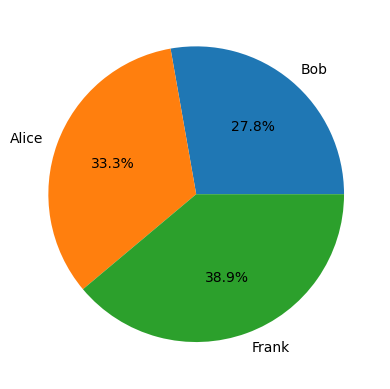

In [35]:
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

from langchain.python import PythonREPL
from langchain.llms.openai import OpenAI
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

agent = create_python_agent(
    llm=llm,
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

result = agent.run('create a sample dataframe about the salary of bob, alice, and frank. Then return a matplotlib piechart of their three salaries. Return only the plot as output.')

- We will define the list of tools for our agent

In [38]:
from langchain.tools.file_management import (
    ReadFileTool,
    CopyFileTool,
    DeleteFileTool,
    MoveFileTool,
    WriteFileTool,
    ListDirectoryTool,
)
from langchain.agents.agent_toolkits import FileManagementToolkit

working_directory  = os.getcwd()

tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"],).get_tools()
tools.append(PythonREPLTool())

tools.extend(SQLDatabaseToolkit(db=db, llm=llm).get_tools())

- In order to leverage that heterogeneous set of tools – SQL Database, Python REPL, and File System (https://python.langchain.com/v0.1/docs/integrations/tools/filesystem/) – we cannot work anymore with the SQL Database-specific agent, since its default configurations are meant to only accept SQL-related contents. Henceforth, we need to set up an agnostic agent that is able to use all of the tools that we provide it with. For this purpose, we are going to use the STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION agent type, which is able to use a multi-tool input.



> Entering new AgentExecutor chain...
Thought: First, we need to use the sql_db_query tool to query the chinook.db database for the top 5 countries for sales. We can do this by writing an SQL query that sorts the invoices table by total sales in descending order, limits the results to 5, and groups them by country. Then, we can use the sql_db_query tool to execute this query and retrieve the results. We can then use the sql_db_schema tool to check the table fields and make sure our query is correct before executing it.

Action:
```
{
  "action": "sql_db_query",
  "action_input": "SELECT invoices.BillingCountry, SUM(invoice_items.UnitPrice * invoice_items.Quantity) AS total_sales FROM invoices INNER JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId GROUP BY invoices.BillingCountry ORDER BY total_sales DESC LIMIT 5"
}
```

Observation: [('USA', 523.060000000003), ('Canada', 303.96000000000134), ('France', 195.1000000000003), ('Brazil', 190.10000000000028), ('Germany', 

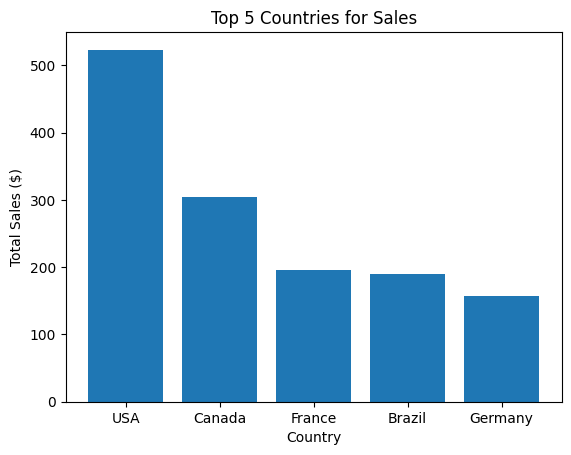

 Now that we have the results, we can use the Python_REPL tool to import pandas and create a dataframe with the results. Then, we can use the matplotlib library to create a bar chart and display it below.
Action:
```
{
  "action": "Python_REPL",
  "action_input": "import pandas as pd\ndf = pd.DataFrame([('USA', 523.060000000003), ('Canada', 303.96000000000134), ('France', 195.1000000000003), ('Brazil', 190.10000000000028), ('Germany', 156.48)], columns=['Country', 'Total Sales'])\nimport matplotlib.pyplot as plt\nplt.bar(df['Country'], df['Total Sales'])\nplt.title('Top 5 Countries for Sales')\nplt.xlabel('Country')\nplt.ylabel('Total Sales ($)')\nplt.show()"
}
```


Observation: 
Thought: I have completed the task and have a bar chart to display the top 5 countries for sales.
Action:
```
{
  "action": "Final Answer",
  "action_input": "Here is a bar chart showing the top 5 countries for sales:\n[[Image: Top 5 Countries for Sales Bar Chart]]"
}
```

> Finished chain.


'Here is a bar chart showing the top 5 countries for sales:\n[[Image: Top 5 Countries for Sales Bar Chart]]'

In [41]:
from langchain.llms import OpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

agent = initialize_agent(
    tools, llm, agent= AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)
agent.run("extract the top 5 countries for sales from the chinook.db database and save it as pandas dataframe. Then return and show below a matplotlib bar chart")

In [44]:
PREFIX = """
Answer the following questions as best you can.
You have access to the following tools:

"""
FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question"""
SUFFIX = """Begin!

Question: {input}
Thought:{agent_scratchpad}"""

agent = initialize_agent(tools, model, agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose = True,
                         agent_kwargs={
                            'prefix':PREFIX,
                            'format_instructions': FORMAT_INSTRUCTIONS,
                            'suffix': SUFFIX})

## We can use this agent call to run the above query.

#### Three Paths to Table Understanding with LLMs

- Three groups of table serialization techniques:
    - text-based methods,
    - embedding-based methods,
    - graph-based & tree-based methods.

- Text-based serialization methods includes a variety of approaches:
    - DFLoader — simply use Pandas DataFrame as an input to an LLM
    - JSON — transform your data table into a JSON format
    - Data Matrix — transformation into a data matrix
    - Markdown — transform the table into Markdown, that’s one of the most popular approaches
    - X-Separated — transform the table into X-separated values where X could be a reasonable delimiter like tab or comma
    - Attribute-Value pairs — transform the table into pairs like name:helen, age:47
    - HTML — use transformation to HTML
    - Sentences — convert the table into a text like “name is helen, age is 47”.

- The second option, one can employ table encoders, which were fine-tuned from pre-trained LMs, to encode tabular data into numerical representations as the input for LLMs. 
- The third but rarely used option is to convert a table to a tree or a graph. However, when working with sequence-to-sequence models, these structures must still be converted back to text. After converting the table into a tree, each cell’s hierarchical structure, position information, and content was represented as a tuple and fed into GPT3.5.

How to create context and a prompt?
- As we pass tabular data as context in a prompt, we immediately face an issue for context size. Some models have short context windows and your table may not fit in it. But even it does, LLMs are inefficient in dealing with long sequences paying attention to the beginning or end of the context window mostly.
- There’s no straightforward solution. Some researches propose to naively truncate the table which has little sense in practice. Others seek to implement additional instruments to first select only relevant tables, rows, or columns. 
- However there are some useful tips regarding prompt engineering:
    - Include additional information about tables (schemas and statistics).
    - Use in-context learning 1-shot or 2-shot learning benefits the model
    - Experiment with Chain-of-Thought, Self-Consistency techniques. 

What kind of framework to build?
- Numeric QA is a framework consisting of just an LLM meaning that we will directly ask the model a question like “What is the average payment volume per transaction for American Express?”.
- Operation-based QA is a framework which includes an additional step of deciding which kind of operations, tables, rows, or columns to use. 
- Text2SQL: SQL generation is popular in the industry, with many open-source fine-tuned models available. As we will be seeing below, "Text2SQL gave maximum number of correct answer with respect to other approach in this section". 

In [45]:
import os
import json
import sqlite3
import openai
import numpy as np
import pandas as pd

from langchain.chains import LLMChain
# from langchain_openai import OpenAI
from langchain import PromptTemplate
# from langchain_community.llms import OpenAI

In [46]:
from langchain.llms import OpenAI, OpenAIChat
os.environ["OPEN_API_KEY"]=""
llm = OpenAI(openai_api_key=os.environ["OPEN_API_KEY"], model_name="gpt-3.5-turbo-instruct") 

In [48]:
db_path = 'data/olist.sqlite'
db_connection = sqlite3.connect(db_path)
cur = db_connection.cursor()

In [49]:
def execute_query(query):
    return pd.read_sql_query(query, db_connection)

In [50]:
orders = execute_query('SELECT * FROM order_items')
orders.sample(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
92687,d23ff5dc2ba7e3aeb50eb93b6c3204e5,1,f90c81e1fa9b03873a387e7919e99b59,6df688df543f90e9b38f4319e75a9d88,2017-10-30 18:14:41,54.00,14.13
61069,8b2f6212e3a5681805601bad0a43905c,1,3e442d09f9dfef002aadf31960869f65,85d9eb9ddc5d00ca9336a2219c97bb13,2017-03-15 13:30:09,20.90,14.11
20001,2de6bd1e34af702eb3e73c1047807cda,1,45a6892a98568b366b52ffeec9a03691,6f1a1263039c76e68f40a8e536b1da6a,2017-09-22 00:50:09,34.96,15.10
84601,c039d465e2d9486915f6356a2660e66f,1,4182ad8f6fd91b6064f2d1097d8a4291,b56906f7fd1696e043f1bcce164c487b,2017-11-03 03:10:29,34.99,20.84


In [51]:
products = execute_query('SELECT * FROM products')
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


##### Numeric QA

In [52]:
df = execute_query("SELECT COUNT(*) as Number_of_products FROM products  WHERE product_category_name = 'perfumaria'")
df

,Number_of_products
0,868


In [53]:
numeric_qa_prompt = """[INST] You are a task answering user questions ONLY based on the provided data frame.

[EXAMPLE]For example:
User question: "How many products of category perfumaria are there?"
Answer: "There are 868 products of category perfumaria."
[/EXAMPLE]

Answer should be specific and precise, don't add anything else!
If you can't answer the question based on the provided data, say so, don't try to guess!

User question: {text}
Data frame: {table}
[/INST]"""


def numeric_qa(question, dataframe, model=llm, qa_prompt=numeric_qa_prompt, to_html=False):
    """
    A function that passes a prompt, question and table to the LLM.
    There's an option of converting a data frame to HTML.
    """

    if to_html:
        dataframe = dataframe.to_html()
    prompt_qa = PromptTemplate(template=qa_prompt, input_variables=["text", "table"])
    llm_chain = LLMChain(prompt=prompt_qa, llm=model)
    llm_reply = llm_chain.predict(text = question, table = dataframe)
    return print(llm_reply)

In [58]:
numeric_qa("What is average product weight?", products)


The average product weight is 1,020.19 grams (or approximately 1.02 kilograms).


In [61]:
numeric_qa("How many products of category esporte_lazer are there ?", products)



There are 2960 products of category esporte_lazer.


In [63]:
numeric_qa("How many products of category esporte_lazer are there that are longer than 30 ?", products)



There are 107 products of category esporte_lazer that are longer than 30.


In [64]:
numeric_qa("What are top three products of the largest product_weight_g?", products)



There is no specific information available on the top three products of the largest product_weight_g.


Conclusion:
- good for simple questions about a specific row,
- has problems with sorting, aggregation and other complicated tasks.

##### Operation-based QA

- The idea is: Once a user question is passed to the framework, it selects the most suitable operation from the operation pool. Possible operations are sorting, adding a column, selecting a row and grouping. Then the framework generates new arguments for the selected operation (like a name of a new column) and thansforms the data. Next, it checks whether next operations are required or the task is complete.
- Below is the approach using ChainOfTablePack.

In [65]:
!llamaindex-cli download-llamapack ChainOfTablePack --download-dir ./chain_of_table_pack

Processing /Users/nisargmehta/Documents/LLM/langchain/Projects/Structured Data/chain_of_table_pack
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-index-packs-tables: filename=llama_index_packs_tables-0.1.3-py3-none-any.whl size=13062 sha256=97e55c26dfe18a24cb2e7f65bed9e0b8047f2e6a197898d113a75e8d56513f72
  Stored in directory: /private/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/pip-ephem-wheel-cache-9ji5awhi/wheels/41/75/2c/5f3f7b59d8c957f27fbcdfa3a68a9c1edaac0b1b9b0b73d81c
Successfully built llama-index-packs-tables
Successfully downloaded ChainOfTablePack to ./chain_of_table_pack


In [78]:
import os
from llama_index.llms.openai import OpenAI
from llama_index.packs.tables.chain_of_table.base import ChainOfTableQueryEngine, serialize_table

In [73]:
prompt = """[INST] You are a task answering user questions ONLY based on the provided data frame.
[EXAMPLE]
Here is the table to answer this question. Please understand the table and answer the
question:
/*
col : Rank | City | Passengers Number | Ranking | Airline
row 1 : 1 | United States, Los Angeles | 14749 | 2 | Alaska Airlines
row 2 : 2 | United States, Houston | 5465 | 8 | United Express
row 3 : 3 | Canada, Calgary | 3761 | 5 | Air Transat, WestJet
row 4 : 4 | Canada, Saskatoon | 2282 | 4 |
row 5 : 5 | Canada, Vancouver | 2103 | 2 | Air Transat
row 6 : 6 | United States, Phoenix | 1829 | 1 | US Airways
row 7 : 7 | Canada, Toronto | 1202 | 1 | Air Transat, CanJet
row 8 : 8 | Canada, Edmonton | 110 | 2 |
row 9 : 9 | United States, Oakland | 107 | 5 |
*/
Question: how many more passengers flew to los angeles than to saskatoon from manzanillo
airport in 2013?
The anwser is: 12467
Here is the table to answer this question. Please understand the table and answer the
question:
/*
col : Rank | Country
row 1 : 1 | ESP
row 2 : 2 | RUS
row 3 : 3 | ITA
row 4 : 4 | ITA
row 5 : 5 | ITA
row 6 : 6 | RUS
row 7 : 7 | ESP
row 8 : 8 | FRA
row 9 : 9 | ESP
row 10 : 10 | FRA
*/
Group the rows according to column "Country":
/*
Group ID | Country | Count
1 | ITA | 3
2 | ESP | 3
3 | RUS | 2
4 | FRA | 2
*/
Question: which country had the most cyclists in top 10?
The answer is:
======================================= Completion =======================================
Italy.[\EXAMPLE]

Question: [question]
Table: [table]
"""

In [80]:
def chain_of_table(question, df, llm=llm):
    query_engine = ChainOfTableQueryEngine(df, llm=llm, verbose=True)
    response = query_engine.query(question)
    return print(response)

In [82]:
# The table is too large for the pack, so I use a subset instead:
chain_of_table("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?", products.iloc[:20])
# >> assistant: 14.0 cm. # Correct!

chain_of_table("Which product has the largest width?", products.iloc[:20])
# >> assistant: f53103a77d9cf245e579ea37e5ec51f0 # Incorrect!

##### Text2SQL

In [83]:
table_description = """The first table is 'products'.
It includes information about products.
The table includes columns:
- product_id (str) - unique key of a product,
- product_category_name (str) - name of product category in Spanish,
- product_name_lenght (float ) - number of characters in a product name,
- product_description_length (float) - number of characters in product description,
- product_photos_qty (float) - number of product photos,
- product_weight_g (float) - weight of product in grams,
- product_length_cm (float) - product length in centimeters,
- product_height_cm (float) - product height in centimeters,
- product_width_cm (float) - product width in centimeters.

The second table is 'product_category_name_translation'. It contains mapping of English and Spanish names of products.
The columns are:
- product_category_name (str) - name of product category in Spanish,
- product_category_name_english (str) - name of product category in English.

The third table is 'order_items'. It contains information about orders.
The columns are:
- order_id (str) - unique key of an order,
- order_item_id (int) - item quantity,
- product_id (str) - key of an ordered product.
- seller_id (str) - key of a seller,
- shipping_limit_date (datetime) - date of shipping,
- price (float) - price of a product,
- freight_value (float) - freight calue of a product.

"""

In [84]:
example = execute_query("""SELECT SUM(freight_value)
FROM order_items as o
LEFT JOIN products as p on p.product_id = o.product_id
LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
WHERE shipping_limit_date >= '2017-01-01' AND shipping_limit_date < '2018-01-01'
    AND product_category_name_english='health_beauty'
    """)
example

,SUM(freight_value)
0,67269.31


In [85]:
template_question_to_sql = """[INST] You are given data tables in SQLite.

[DATA_DESCRIPTION]
{data_description}
[\DATA_DESCRIPTION]

Your task is to identify what data are required to answer a user's question and
to generate a valid SQL query for SQLite that will include data required to answer a user's question.

Answer is a JSON: {{"sql_query":  valid_sql_query}}. Don't add anything else.
When merging two tables add a table identifier.
If you can't provide an answer based on the tables, say so.

[EXAMPLE]For example:
User question: "What is the total freight value of health_beauty items in 2017?"
Expected answer in JSON: {{"sql_query": "SELECT SUM(freight_value)
                                         FROM order_items as o
                                         LEFT JOIN products as p on p.product_id = o.product_id
                                         LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
                                         WHERE shipping_limit_date >= '2017-01-01'
                                            AND shipping_limit_date < '2018-01-01'
                                            AND product_category_name_english='health_beauty'"}}
[/EXAMPLE]

User question: {text}
[/INST]"""

In [86]:
template_sql_to_insight = """[INST] You are a task answering user questions ONLY based on the provided data frame and an SQL query used to generate the table.

[EXAMPLE]For example:
User question: "What is the total freight value of health_beauty items in 2017?"
SQL query: "SELECT SUM(freight_value)
            FROM order_items as o
            LEFT JOIN products as p on p.product_id = o.product_id
            LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
            WHERE shipping_limit_date >= '2017-01-01'
                AND shipping_limit_date < '2018-01-01'
                AND product_category_name_english='health_beauty'"
Data frame: "	SUM(freight_value)
            0   67269.31"
Answer: "The total freight value of 'health beauty' products ordered in 2017 is 67269.31."
[/EXAMPLE]

Answer should be specific and precise, don't add anything else!
If you can't answer the question based on the provided data, say so, don't try to guess!

User question: {text}
SQL query: {sql_query}
Data frame: {table}
[/INST]"""

In [87]:
def text2sql(question, llm_model = llm, question_to_sql_prompt=template_question_to_sql, df_to_insight_prompt = template_sql_to_insight, data_description = table_description):
    
    # Get data frame:
    prompt_sql = PromptTemplate(template=question_to_sql_prompt, input_variables=["text", "data_description"])
    llm_chain = LLMChain(prompt=prompt_sql, llm=llm_model)
    llm_reply = llm_chain.predict(text = question, data_description = data_description)
    print(llm_reply)
    json_reply = json.loads(llm_reply.replace('\n',' '))
    sql_query = json_reply['sql_query']
    df_reply = execute_query(sql_query)
    print(df_reply)

    # Get insight
    prompt_insight = PromptTemplate(template=df_to_insight_prompt, input_variables=["text", "sql_query", "table"])
    llm_chain = LLMChain(prompt=prompt_insight, llm=llm_model)
    llm_reply = llm_chain.predict(text = question, sql_query = sql_query, table = df_reply)
    return print(llm_reply)

In [88]:
text2sql("What is the width of product 1e9e8ef04dbcff4541ed26657ea517e5?")



{"sql_query": "SELECT product_width_cm 
                FROM products 
                WHERE product_id = '1e9e8ef04dbcff4541ed26657ea517e5'"}
   product_width_cm
0              14.0


The width of product 1e9e8ef04dbcff4541ed26657ea517e5 is 14.0 cm.


In [89]:
#check:
products.loc[products['product_id'] == '1e9e8ef04dbcff4541ed26657ea517e5', 'product_width_cm']    

0    14.0
Name: product_width_cm, dtype: float64

In [90]:
text2sql("What is the heaviest product?")


{"sql_query": "SELECT product_id, MAX(product_weight_g) AS heaviest_product
                FROM products"}
                         product_id  heaviest_product
0  26644690fde745fc4654719c3904e1db           40425.0

The heaviest product is the one with product_id '26644690fde745fc4654719c3904e1db' and a weight of 40425 grams.


In [91]:
text2sql("How many products of category esporte_lazer are there ?")



{"sql_query": "SELECT COUNT(*) 
                FROM products as p
                LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
                WHERE product_category_name_english = 'esporte_lazer'"}
   COUNT(*)
0         0

There are 0 products of category 'esporte_lazer'.


In [93]:
# check: ## Giving the incorrect result from text2sql as shown in above cell
products.loc[products['product_category_name'] == 'esporte_lazer',].shape[0]

2867

In [95]:
text2sql("What is the heaviest product of category health_beauty?")
# The heaviest product in the 'health beauty' category weighs 30000 grams.



{"sql_query": "SELECT MAX(p.product_weight_g) 
               FROM products as p 
               LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name 
               WHERE product_category_name_english='health_beauty'"}
   MAX(p.product_weight_g)
0                  30000.0


The heaviest product in the 'health beauty' category is 30000.0 grams.


In [97]:
# Three tables:
text2sql("Who sold most of health_beauty products?")



{"sql_query": "SELECT seller_id, COUNT(*) AS total_sales
               FROM order_items as o
               LEFT JOIN products as p on p.product_id = o.product_id
               LEFT JOIN product_category_name_translation as c on c.product_category_name = p.product_category_name
               WHERE product_category_name_english='health_beauty'
               GROUP BY seller_id
               ORDER BY total_sales DESC
               LIMIT 1"}
                          seller_id  total_sales
0  cc419e0650a3c5ba77189a1882b7556a         1091


The seller with ID 'cc419e0650a3c5ba77189a1882b7556a' sold the most 'health beauty' products with a total of 1091 sales.


Text2SQL gave maximum number of correct answer with respect to other approach in this section

#### Tabular Data Exploration and Modelling with LLMs

##### EDA with LLM

- PandasAI would use the LLM power to help us explore and clean data. It would be conversational tools that we can use to ask Pandas to manipulate data in a way we want.

In [1]:
import pandas as pd

df = pd.read_csv('data/telecom_churn.csv')
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [4]:
import os
from pandasai.llm import OpenAI
os.environ["OPEN_API_KEY"]=""
openai_api_key = os.environ['OPEN_API_KEY']
llm = OpenAI(api_token=os.environ["OPEN_API_KEY"])

Then, we would transform our Pandas DataFrame into a SmartDataFrame object that can accept conversational input

In [6]:
from pandasai import SmartDataframe
df = SmartDataframe(df, config = {'llm': llm})

In [7]:
response = df.chat("Can you provide me the detailed statistic of this dataset")
response

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


##### Tabular Model Development with LLM

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('data/telecom_churn.csv')

X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis =1), df['Churn'], test_size=.2, random_state = 42)

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.metrics import f1_score

print('F1 Score: ', f1_score(y_test, y_pred)) 

F1 Score:  0.22727272727272727


- With the Logistic Regression model in place, we would compare it with the LLM model if we try to create the prediction.
- For this case, we need to transform the tabular data into a form that LLM could accept. That's why the code below would focus on transforming data into text.

In [17]:
def concatenate_text(x):
    if x['ContractRenewal'] == 1:
      cr = 'have renew the contract'
    else:
      cr = 'never renew the contract'

    if x['DataPlan'] == 1:
      dp = 'have data plan'
    else:
      dp = "doesn't have data plan"

    full_text = (
        f"This customer account is {x['AccountWeeks']} weeks old, ",
        f"{cr}, ",
        f"{dp}, ",
        f"with {x['DataUsage']} GB of Monthly Data Usage, ",
        f"{x['CustServCalls']} times of Customer Service Calls, " ,
        f"{x['DayMins']} minutes total usage average monthly, ",
        f"{x['DayCalls']} times in average of daytime calls, "
        f"{x['MonthlyCharge']} monthly bill average, "
        f"with the largest overage Fee in the last 12 month is {x['OverageFee']}, "
        f"and {x['RoamMins']} minutes in average for roaming"

    )
    return ''.join(full_text)

X_train['label'] = y_train
X_test['label'] = y_test

X_train['text'] = X_train.apply(lambda x: concatenate_text(x), axis=1)
X_test['text'] = X_test.apply(lambda x: concatenate_text(x), axis=1)

Next, we would fine-tune an LLM model for text classification purposes. I would use the BERT base model as the foundation model for the classification.

In [20]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import evaluate

# label mapping
id2label = {0: "NOT-CHURN", 1: "CHURN"}
label2id = {"NOT-CHURN": 0, "CHURN": 1}

# dataset formatting
train_dataset = Dataset.from_pandas(X_train)
test_dataset = Dataset.from_pandas(X_test)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tweak the tokenizer function as you need
def tokenize_fn(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_fn, batched=True)
tokenized_test= test_dataset.map(tokenize_fn, batched=True)

tokenized_train_dataset = tokenized_train.map(lambda x: {'labels': x['label']})
tokenized_test_dataset = tokenized_test.map(lambda x: {'labels': x['label']})

Map: 100%|██████████| 667/667 [00:00<00:00, 16762.24 examples/s]


In [21]:
# Model with the label mappings
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Model with training arguments. Tweaks the parameter as you need
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Evaluation metric. We choose F1
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return f1.compute(predictions=predictions, references=labels)

# Set the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 10/1670 [00:06<08:55,  3.10it/s] 

{'loss': 0.4889, 'grad_norm': 5.8668975830078125, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  1%|          | 20/1670 [00:08<07:39,  3.59it/s]

{'loss': 0.4854, 'grad_norm': 7.605673789978027, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  2%|▏         | 30/1670 [00:11<07:32,  3.63it/s]

{'loss': 0.5388, 'grad_norm': 2.0090012550354004, 'learning_rate': 3e-06, 'epoch': 0.09}


  2%|▏         | 40/1670 [00:14<07:28,  3.63it/s]

{'loss': 0.3894, 'grad_norm': 2.7741880416870117, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}


  3%|▎         | 50/1670 [00:17<07:26,  3.63it/s]

{'loss': 0.3817, 'grad_norm': 6.8861494064331055, 'learning_rate': 5e-06, 'epoch': 0.15}


  4%|▎         | 60/1670 [00:19<07:24,  3.63it/s]

{'loss': 0.4558, 'grad_norm': 2.7952206134796143, 'learning_rate': 6e-06, 'epoch': 0.18}


  4%|▍         | 70/1670 [00:22<07:33,  3.53it/s]

{'loss': 0.4123, 'grad_norm': 7.330334663391113, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.21}


  5%|▍         | 80/1670 [00:25<07:21,  3.60it/s]

{'loss': 0.4592, 'grad_norm': 1.5174626111984253, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.24}


  5%|▌         | 90/1670 [00:28<07:16,  3.62it/s]

{'loss': 0.3811, 'grad_norm': 4.050023555755615, 'learning_rate': 9e-06, 'epoch': 0.27}


  6%|▌         | 100/1670 [00:31<07:28,  3.50it/s]

{'loss': 0.4965, 'grad_norm': 1.825079321861267, 'learning_rate': 1e-05, 'epoch': 0.3}


  7%|▋         | 110/1670 [00:34<07:24,  3.51it/s]

{'loss': 0.3933, 'grad_norm': 3.7556447982788086, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.33}


  7%|▋         | 120/1670 [00:36<07:16,  3.55it/s]

{'loss': 0.4618, 'grad_norm': 7.704730987548828, 'learning_rate': 1.2e-05, 'epoch': 0.36}


  8%|▊         | 130/1670 [00:39<07:12,  3.56it/s]

{'loss': 0.3868, 'grad_norm': 10.940210342407227, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.39}


  8%|▊         | 140/1670 [00:42<07:05,  3.60it/s]

{'loss': 0.3659, 'grad_norm': 3.4106380939483643, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.42}


  9%|▉         | 150/1670 [00:45<07:13,  3.51it/s]

{'loss': 0.3948, 'grad_norm': 2.64888596534729, 'learning_rate': 1.5e-05, 'epoch': 0.45}


 10%|▉         | 160/1670 [00:48<07:03,  3.56it/s]

{'loss': 0.2873, 'grad_norm': 7.357054233551025, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.48}


 10%|█         | 170/1670 [00:51<07:10,  3.48it/s]

{'loss': 0.4382, 'grad_norm': 5.752063751220703, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.51}


 11%|█         | 180/1670 [00:54<07:10,  3.46it/s]

{'loss': 0.2838, 'grad_norm': 5.959490776062012, 'learning_rate': 1.8e-05, 'epoch': 0.54}


 11%|█▏        | 190/1670 [00:56<07:42,  3.20it/s]

{'loss': 0.3323, 'grad_norm': 1.5545361042022705, 'learning_rate': 1.9e-05, 'epoch': 0.57}


 12%|█▏        | 200/1670 [00:59<06:58,  3.51it/s]

{'loss': 0.5187, 'grad_norm': 5.835117340087891, 'learning_rate': 2e-05, 'epoch': 0.6}


 13%|█▎        | 210/1670 [01:02<06:45,  3.60it/s]

{'loss': 0.5389, 'grad_norm': 3.1408114433288574, 'learning_rate': 2.1e-05, 'epoch': 0.63}


 13%|█▎        | 220/1670 [01:05<07:04,  3.41it/s]

{'loss': 0.4925, 'grad_norm': 1.7925256490707397, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.66}


 14%|█▍        | 230/1670 [01:08<06:53,  3.48it/s]

{'loss': 0.4613, 'grad_norm': 6.6035943031311035, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.69}


 14%|█▍        | 240/1670 [01:11<06:41,  3.56it/s]

{'loss': 0.4328, 'grad_norm': 1.3407866954803467, 'learning_rate': 2.4e-05, 'epoch': 0.72}


 15%|█▍        | 250/1670 [01:13<06:41,  3.54it/s]

{'loss': 0.3208, 'grad_norm': 1.8319226503372192, 'learning_rate': 2.5e-05, 'epoch': 0.75}


 16%|█▌        | 260/1670 [01:16<06:34,  3.57it/s]

{'loss': 0.4797, 'grad_norm': 3.9044809341430664, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.78}


 16%|█▌        | 270/1670 [01:19<06:29,  3.59it/s]

{'loss': 0.3558, 'grad_norm': 4.602632999420166, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.81}


 17%|█▋        | 280/1670 [01:22<06:24,  3.61it/s]

{'loss': 0.3819, 'grad_norm': 4.169885158538818, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.84}


 17%|█▋        | 290/1670 [01:25<06:27,  3.56it/s]

{'loss': 0.3794, 'grad_norm': 1.2475417852401733, 'learning_rate': 2.9e-05, 'epoch': 0.87}


 18%|█▊        | 300/1670 [01:28<06:28,  3.53it/s]

{'loss': 0.3697, 'grad_norm': 5.296911239624023, 'learning_rate': 3e-05, 'epoch': 0.9}


 19%|█▊        | 310/1670 [01:30<06:29,  3.49it/s]

{'loss': 0.5877, 'grad_norm': 14.343379020690918, 'learning_rate': 3.1e-05, 'epoch': 0.93}


 19%|█▉        | 320/1670 [01:33<06:27,  3.49it/s]

{'loss': 0.4064, 'grad_norm': 2.767699956893921, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.96}


 20%|█▉        | 330/1670 [01:36<06:15,  3.57it/s]

{'loss': 0.4191, 'grad_norm': 1.1659345626831055, 'learning_rate': 3.3e-05, 'epoch': 0.99}


 20%|██        | 334/1670 [01:44<12:35,  1.77it/s]

{'eval_loss': 0.4428458511829376, 'eval_f1': 0.0, 'eval_runtime': 5.8261, 'eval_samples_per_second': 114.485, 'eval_steps_per_second': 14.418, 'epoch': 1.0}


 20%|██        | 340/1670 [01:46<13:49,  1.60it/s]

{'loss': 0.2984, 'grad_norm': 2.077877998352051, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.02}


 21%|██        | 350/1670 [01:49<06:21,  3.46it/s]

{'loss': 0.3383, 'grad_norm': 2.1599626541137695, 'learning_rate': 3.5e-05, 'epoch': 1.05}


 22%|██▏       | 360/1670 [01:52<06:15,  3.49it/s]

{'loss': 0.5659, 'grad_norm': 1.5518062114715576, 'learning_rate': 3.6e-05, 'epoch': 1.08}


 22%|██▏       | 370/1670 [01:54<06:05,  3.56it/s]

{'loss': 0.4632, 'grad_norm': 5.916694641113281, 'learning_rate': 3.7e-05, 'epoch': 1.11}


 23%|██▎       | 380/1670 [01:57<06:00,  3.58it/s]

{'loss': 0.3999, 'grad_norm': 3.63181471824646, 'learning_rate': 3.8e-05, 'epoch': 1.14}


 23%|██▎       | 390/1670 [02:00<05:54,  3.61it/s]

{'loss': 0.3876, 'grad_norm': 4.680431842803955, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.17}


 24%|██▍       | 400/1670 [02:03<05:50,  3.62it/s]

{'loss': 0.3426, 'grad_norm': 1.3198498487472534, 'learning_rate': 4e-05, 'epoch': 1.2}


 25%|██▍       | 410/1670 [02:06<05:52,  3.57it/s]

{'loss': 0.4953, 'grad_norm': 1.665381669998169, 'learning_rate': 4.1e-05, 'epoch': 1.23}


 25%|██▌       | 420/1670 [02:08<05:45,  3.61it/s]

{'loss': 0.4638, 'grad_norm': 7.521394729614258, 'learning_rate': 4.2e-05, 'epoch': 1.26}


 26%|██▌       | 430/1670 [02:11<05:42,  3.62it/s]

{'loss': 0.566, 'grad_norm': 7.558049201965332, 'learning_rate': 4.3e-05, 'epoch': 1.29}


 26%|██▋       | 440/1670 [02:14<05:40,  3.61it/s]

{'loss': 0.3654, 'grad_norm': 1.2585800886154175, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.32}


 27%|██▋       | 450/1670 [02:17<05:37,  3.62it/s]

{'loss': 0.3422, 'grad_norm': 2.062209129333496, 'learning_rate': 4.5e-05, 'epoch': 1.35}


 28%|██▊       | 460/1670 [02:19<05:33,  3.63it/s]

{'loss': 0.4465, 'grad_norm': 4.7503509521484375, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.38}


 28%|██▊       | 470/1670 [02:22<05:31,  3.62it/s]

{'loss': 0.3562, 'grad_norm': 2.8443243503570557, 'learning_rate': 4.7e-05, 'epoch': 1.41}


 29%|██▊       | 480/1670 [02:25<05:28,  3.62it/s]

{'loss': 0.6027, 'grad_norm': 10.23948860168457, 'learning_rate': 4.8e-05, 'epoch': 1.44}


 29%|██▉       | 490/1670 [02:28<05:25,  3.62it/s]

{'loss': 0.4267, 'grad_norm': 1.193809986114502, 'learning_rate': 4.9e-05, 'epoch': 1.47}


 30%|██▉       | 500/1670 [02:30<05:23,  3.62it/s]

{'loss': 0.3049, 'grad_norm': 3.489506959915161, 'learning_rate': 5e-05, 'epoch': 1.5}


 31%|███       | 510/1670 [02:35<05:38,  3.42it/s]

{'loss': 0.4138, 'grad_norm': 1.5312869548797607, 'learning_rate': 4.9572649572649575e-05, 'epoch': 1.53}


 31%|███       | 520/1670 [02:38<05:14,  3.66it/s]

{'loss': 0.4514, 'grad_norm': 2.7996082305908203, 'learning_rate': 4.9145299145299147e-05, 'epoch': 1.56}


 32%|███▏      | 530/1670 [02:40<05:12,  3.65it/s]

{'loss': 0.411, 'grad_norm': 4.143256664276123, 'learning_rate': 4.871794871794872e-05, 'epoch': 1.59}


 32%|███▏      | 540/1670 [02:43<05:09,  3.65it/s]

{'loss': 0.3641, 'grad_norm': 2.1700921058654785, 'learning_rate': 4.829059829059829e-05, 'epoch': 1.62}


 33%|███▎      | 550/1670 [02:46<05:06,  3.66it/s]

{'loss': 0.2683, 'grad_norm': 3.3267009258270264, 'learning_rate': 4.786324786324787e-05, 'epoch': 1.65}


 34%|███▎      | 560/1670 [02:48<05:04,  3.65it/s]

{'loss': 0.5321, 'grad_norm': 9.4354829788208, 'learning_rate': 4.7435897435897435e-05, 'epoch': 1.68}


 34%|███▍      | 570/1670 [02:51<05:01,  3.64it/s]

{'loss': 0.4489, 'grad_norm': 3.240812301635742, 'learning_rate': 4.700854700854701e-05, 'epoch': 1.71}


 35%|███▍      | 580/1670 [02:54<04:59,  3.64it/s]

{'loss': 0.4471, 'grad_norm': 6.742738723754883, 'learning_rate': 4.6581196581196586e-05, 'epoch': 1.74}


 35%|███▌      | 590/1670 [02:57<04:56,  3.65it/s]

{'loss': 0.3654, 'grad_norm': 5.967387676239014, 'learning_rate': 4.615384615384616e-05, 'epoch': 1.77}


 36%|███▌      | 600/1670 [02:59<04:52,  3.66it/s]

{'loss': 0.4584, 'grad_norm': 2.6292645931243896, 'learning_rate': 4.572649572649573e-05, 'epoch': 1.8}


 37%|███▋      | 610/1670 [03:02<04:50,  3.65it/s]

{'loss': 0.3592, 'grad_norm': 5.147336483001709, 'learning_rate': 4.52991452991453e-05, 'epoch': 1.83}


 37%|███▋      | 620/1670 [03:05<04:46,  3.66it/s]

{'loss': 0.4232, 'grad_norm': 3.149099111557007, 'learning_rate': 4.4871794871794874e-05, 'epoch': 1.86}


 38%|███▊      | 630/1670 [03:08<04:44,  3.66it/s]

{'loss': 0.3855, 'grad_norm': 1.4474109411239624, 'learning_rate': 4.4444444444444447e-05, 'epoch': 1.89}


 38%|███▊      | 640/1670 [03:10<04:47,  3.58it/s]

{'loss': 0.4233, 'grad_norm': 1.5100250244140625, 'learning_rate': 4.401709401709402e-05, 'epoch': 1.92}


 39%|███▉      | 650/1670 [03:13<04:38,  3.66it/s]

{'loss': 0.389, 'grad_norm': 6.084747314453125, 'learning_rate': 4.358974358974359e-05, 'epoch': 1.95}


 40%|███▉      | 660/1670 [03:16<04:36,  3.66it/s]

{'loss': 0.4519, 'grad_norm': 3.052718162536621, 'learning_rate': 4.316239316239317e-05, 'epoch': 1.98}


                                                  
 40%|████      | 668/1670 [03:23<03:58,  4.19it/s]

{'eval_loss': 0.4283806383609772, 'eval_f1': 0.0, 'eval_runtime': 4.8662, 'eval_samples_per_second': 137.067, 'eval_steps_per_second': 17.262, 'epoch': 2.0}


 40%|████      | 670/1670 [03:23<21:24,  1.28s/it]

{'loss': 0.5399, 'grad_norm': 2.6203763484954834, 'learning_rate': 4.2735042735042735e-05, 'epoch': 2.01}


 41%|████      | 680/1670 [03:26<05:00,  3.30it/s]

{'loss': 0.4282, 'grad_norm': 6.276249408721924, 'learning_rate': 4.230769230769231e-05, 'epoch': 2.04}


 41%|████▏     | 690/1670 [03:29<04:30,  3.63it/s]

{'loss': 0.456, 'grad_norm': 4.203884124755859, 'learning_rate': 4.1880341880341886e-05, 'epoch': 2.07}


 42%|████▏     | 700/1670 [03:32<04:26,  3.64it/s]

{'loss': 0.501, 'grad_norm': 1.5560195446014404, 'learning_rate': 4.145299145299146e-05, 'epoch': 2.1}


 43%|████▎     | 710/1670 [03:34<04:23,  3.64it/s]

{'loss': 0.3902, 'grad_norm': 7.520972728729248, 'learning_rate': 4.1025641025641023e-05, 'epoch': 2.13}


 43%|████▎     | 720/1670 [03:37<04:21,  3.64it/s]

{'loss': 0.4084, 'grad_norm': 3.1518075466156006, 'learning_rate': 4.05982905982906e-05, 'epoch': 2.16}


 44%|████▎     | 730/1670 [03:40<04:26,  3.53it/s]

{'loss': 0.222, 'grad_norm': 3.1483583450317383, 'learning_rate': 4.0170940170940174e-05, 'epoch': 2.19}


 44%|████▍     | 740/1670 [03:43<04:14,  3.66it/s]

{'loss': 0.2855, 'grad_norm': 2.298267126083374, 'learning_rate': 3.974358974358974e-05, 'epoch': 2.22}


 45%|████▍     | 750/1670 [03:46<04:11,  3.65it/s]

{'loss': 0.3575, 'grad_norm': 2.336143970489502, 'learning_rate': 3.931623931623932e-05, 'epoch': 2.25}


 46%|████▌     | 760/1670 [03:48<04:08,  3.66it/s]

{'loss': 0.3838, 'grad_norm': 8.033416748046875, 'learning_rate': 3.888888888888889e-05, 'epoch': 2.28}


 46%|████▌     | 770/1670 [03:51<04:06,  3.65it/s]

{'loss': 0.4274, 'grad_norm': 4.056546688079834, 'learning_rate': 3.846153846153846e-05, 'epoch': 2.31}


 47%|████▋     | 780/1670 [03:54<04:04,  3.65it/s]

{'loss': 0.489, 'grad_norm': 2.0363423824310303, 'learning_rate': 3.8034188034188035e-05, 'epoch': 2.34}


 47%|████▋     | 790/1670 [03:56<04:01,  3.64it/s]

{'loss': 0.5579, 'grad_norm': 7.384050369262695, 'learning_rate': 3.760683760683761e-05, 'epoch': 2.37}


 48%|████▊     | 800/1670 [03:59<03:58,  3.65it/s]

{'loss': 0.3881, 'grad_norm': 3.5238795280456543, 'learning_rate': 3.717948717948718e-05, 'epoch': 2.4}


 49%|████▊     | 810/1670 [04:02<03:56,  3.64it/s]

{'loss': 0.4627, 'grad_norm': 4.063533782958984, 'learning_rate': 3.675213675213676e-05, 'epoch': 2.43}


 49%|████▉     | 820/1670 [04:05<03:54,  3.63it/s]

{'loss': 0.3651, 'grad_norm': 7.857006549835205, 'learning_rate': 3.6324786324786323e-05, 'epoch': 2.46}


 50%|████▉     | 830/1670 [04:07<03:50,  3.65it/s]

{'loss': 0.4208, 'grad_norm': 1.137831211090088, 'learning_rate': 3.58974358974359e-05, 'epoch': 2.49}


 50%|█████     | 840/1670 [04:10<03:47,  3.65it/s]

{'loss': 0.5307, 'grad_norm': 5.35096549987793, 'learning_rate': 3.5470085470085474e-05, 'epoch': 2.51}


 51%|█████     | 850/1670 [04:13<03:44,  3.66it/s]

{'loss': 0.4042, 'grad_norm': 2.9511876106262207, 'learning_rate': 3.504273504273504e-05, 'epoch': 2.54}


 51%|█████▏    | 860/1670 [04:16<03:41,  3.65it/s]

{'loss': 0.4429, 'grad_norm': 1.429317831993103, 'learning_rate': 3.461538461538462e-05, 'epoch': 2.57}


 52%|█████▏    | 870/1670 [04:18<03:39,  3.65it/s]

{'loss': 0.3705, 'grad_norm': 4.500094413757324, 'learning_rate': 3.418803418803419e-05, 'epoch': 2.6}


 53%|█████▎    | 880/1670 [04:21<03:37,  3.64it/s]

{'loss': 0.4888, 'grad_norm': 1.1213659048080444, 'learning_rate': 3.376068376068376e-05, 'epoch': 2.63}


 53%|█████▎    | 890/1670 [04:24<03:33,  3.65it/s]

{'loss': 0.4248, 'grad_norm': 3.03448486328125, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.66}


 54%|█████▍    | 900/1670 [04:27<03:30,  3.66it/s]

{'loss': 0.463, 'grad_norm': 5.620119571685791, 'learning_rate': 3.290598290598291e-05, 'epoch': 2.69}


 54%|█████▍    | 910/1670 [04:29<03:28,  3.65it/s]

{'loss': 0.4968, 'grad_norm': 2.736828565597534, 'learning_rate': 3.247863247863248e-05, 'epoch': 2.72}


 55%|█████▌    | 920/1670 [04:32<03:25,  3.66it/s]

{'loss': 0.3851, 'grad_norm': 1.8899012804031372, 'learning_rate': 3.205128205128206e-05, 'epoch': 2.75}


 56%|█████▌    | 930/1670 [04:35<03:24,  3.63it/s]

{'loss': 0.3912, 'grad_norm': 3.424572706222534, 'learning_rate': 3.162393162393162e-05, 'epoch': 2.78}


 56%|█████▋    | 940/1670 [04:38<03:19,  3.66it/s]

{'loss': 0.3582, 'grad_norm': 1.744661808013916, 'learning_rate': 3.1196581196581195e-05, 'epoch': 2.81}


 57%|█████▋    | 950/1670 [04:40<03:16,  3.66it/s]

{'loss': 0.3414, 'grad_norm': 2.4383764266967773, 'learning_rate': 3.0769230769230774e-05, 'epoch': 2.84}


 57%|█████▋    | 960/1670 [04:43<03:14,  3.65it/s]

{'loss': 0.3862, 'grad_norm': 6.274414539337158, 'learning_rate': 3.034188034188034e-05, 'epoch': 2.87}


 58%|█████▊    | 970/1670 [04:46<03:11,  3.65it/s]

{'loss': 0.3774, 'grad_norm': 5.839714527130127, 'learning_rate': 2.9914529914529915e-05, 'epoch': 2.9}


 59%|█████▊    | 980/1670 [04:49<03:09,  3.65it/s]

{'loss': 0.4992, 'grad_norm': 1.6587873697280884, 'learning_rate': 2.948717948717949e-05, 'epoch': 2.93}


 59%|█████▉    | 990/1670 [04:51<03:06,  3.65it/s]

{'loss': 0.4523, 'grad_norm': 3.999817132949829, 'learning_rate': 2.9059829059829063e-05, 'epoch': 2.96}


 60%|█████▉    | 1000/1670 [04:54<03:05,  3.62it/s]

{'loss': 0.4015, 'grad_norm': 5.394253253936768, 'learning_rate': 2.863247863247863e-05, 'epoch': 2.99}


                                                   
 60%|██████    | 1002/1670 [05:01<06:05,  1.83it/s]

{'eval_loss': 0.426748663187027, 'eval_f1': 0.0, 'eval_runtime': 4.8453, 'eval_samples_per_second': 137.66, 'eval_steps_per_second': 17.336, 'epoch': 3.0}


 60%|██████    | 1010/1670 [05:03<04:30,  2.44it/s]

{'loss': 0.3797, 'grad_norm': 4.535213470458984, 'learning_rate': 2.8205128205128207e-05, 'epoch': 3.02}


 61%|██████    | 1020/1670 [05:06<02:59,  3.62it/s]

{'loss': 0.3993, 'grad_norm': 1.6178630590438843, 'learning_rate': 2.777777777777778e-05, 'epoch': 3.05}


 62%|██████▏   | 1030/1670 [05:09<02:54,  3.66it/s]

{'loss': 0.4522, 'grad_norm': 1.3046424388885498, 'learning_rate': 2.7350427350427355e-05, 'epoch': 3.08}


 62%|██████▏   | 1040/1670 [05:11<02:52,  3.66it/s]

{'loss': 0.4052, 'grad_norm': 1.1705918312072754, 'learning_rate': 2.6923076923076923e-05, 'epoch': 3.11}


 63%|██████▎   | 1050/1670 [05:14<02:49,  3.65it/s]

{'loss': 0.3327, 'grad_norm': 4.293140411376953, 'learning_rate': 2.64957264957265e-05, 'epoch': 3.14}


 63%|██████▎   | 1060/1670 [05:17<02:46,  3.66it/s]

{'loss': 0.3707, 'grad_norm': 3.4869861602783203, 'learning_rate': 2.606837606837607e-05, 'epoch': 3.17}


 64%|██████▍   | 1070/1670 [05:19<02:43,  3.67it/s]

{'loss': 0.4108, 'grad_norm': 1.6111886501312256, 'learning_rate': 2.564102564102564e-05, 'epoch': 3.2}


 65%|██████▍   | 1080/1670 [05:22<02:41,  3.66it/s]

{'loss': 0.3653, 'grad_norm': 1.225944995880127, 'learning_rate': 2.5213675213675215e-05, 'epoch': 3.23}


 65%|██████▌   | 1090/1670 [05:25<02:37,  3.67it/s]

{'loss': 0.4802, 'grad_norm': 4.39047908782959, 'learning_rate': 2.4786324786324787e-05, 'epoch': 3.26}


 66%|██████▌   | 1100/1670 [05:28<02:35,  3.66it/s]

{'loss': 0.4975, 'grad_norm': 2.8223276138305664, 'learning_rate': 2.435897435897436e-05, 'epoch': 3.29}


 66%|██████▋   | 1110/1670 [05:30<02:33,  3.65it/s]

{'loss': 0.4404, 'grad_norm': 1.3377068042755127, 'learning_rate': 2.3931623931623935e-05, 'epoch': 3.32}


 67%|██████▋   | 1120/1670 [05:33<02:30,  3.65it/s]

{'loss': 0.4546, 'grad_norm': 1.9655698537826538, 'learning_rate': 2.3504273504273504e-05, 'epoch': 3.35}


 68%|██████▊   | 1130/1670 [05:36<02:27,  3.67it/s]

{'loss': 0.4608, 'grad_norm': 6.879478931427002, 'learning_rate': 2.307692307692308e-05, 'epoch': 3.38}


 68%|██████▊   | 1140/1670 [05:39<02:24,  3.66it/s]

{'loss': 0.4249, 'grad_norm': 4.027163982391357, 'learning_rate': 2.264957264957265e-05, 'epoch': 3.41}


 69%|██████▉   | 1150/1670 [05:41<02:22,  3.65it/s]

{'loss': 0.4039, 'grad_norm': 1.2073005437850952, 'learning_rate': 2.2222222222222223e-05, 'epoch': 3.44}


 69%|██████▉   | 1160/1670 [05:44<02:19,  3.66it/s]

{'loss': 0.4255, 'grad_norm': 4.004036903381348, 'learning_rate': 2.1794871794871795e-05, 'epoch': 3.47}


 70%|███████   | 1170/1670 [05:47<02:16,  3.66it/s]

{'loss': 0.3673, 'grad_norm': 3.7739944458007812, 'learning_rate': 2.1367521367521368e-05, 'epoch': 3.5}


 71%|███████   | 1180/1670 [05:50<02:14,  3.65it/s]

{'loss': 0.3984, 'grad_norm': 3.221477746963501, 'learning_rate': 2.0940170940170943e-05, 'epoch': 3.53}


 71%|███████▏  | 1190/1670 [05:52<02:11,  3.66it/s]

{'loss': 0.4437, 'grad_norm': 3.6627163887023926, 'learning_rate': 2.0512820512820512e-05, 'epoch': 3.56}


 72%|███████▏  | 1200/1670 [05:55<02:09,  3.63it/s]

{'loss': 0.5438, 'grad_norm': 1.4382251501083374, 'learning_rate': 2.0085470085470087e-05, 'epoch': 3.59}


 72%|███████▏  | 1210/1670 [05:58<02:06,  3.63it/s]

{'loss': 0.3188, 'grad_norm': 1.4266852140426636, 'learning_rate': 1.965811965811966e-05, 'epoch': 3.62}


 73%|███████▎  | 1220/1670 [06:01<02:03,  3.65it/s]

{'loss': 0.3383, 'grad_norm': 2.9334187507629395, 'learning_rate': 1.923076923076923e-05, 'epoch': 3.65}


 74%|███████▎  | 1230/1670 [06:03<02:00,  3.65it/s]

{'loss': 0.6706, 'grad_norm': 4.004647731781006, 'learning_rate': 1.8803418803418804e-05, 'epoch': 3.68}


 74%|███████▍  | 1240/1670 [06:06<01:57,  3.64it/s]

{'loss': 0.3816, 'grad_norm': 1.4575738906860352, 'learning_rate': 1.837606837606838e-05, 'epoch': 3.71}


 75%|███████▍  | 1250/1670 [06:09<01:55,  3.63it/s]

{'loss': 0.4836, 'grad_norm': 1.2506968975067139, 'learning_rate': 1.794871794871795e-05, 'epoch': 3.74}


 75%|███████▌  | 1260/1670 [06:12<01:52,  3.65it/s]

{'loss': 0.2946, 'grad_norm': 1.2045190334320068, 'learning_rate': 1.752136752136752e-05, 'epoch': 3.77}


 76%|███████▌  | 1270/1670 [06:14<01:49,  3.65it/s]

{'loss': 0.5753, 'grad_norm': 9.902897834777832, 'learning_rate': 1.7094017094017095e-05, 'epoch': 3.8}


 77%|███████▋  | 1280/1670 [06:17<01:47,  3.64it/s]

{'loss': 0.3914, 'grad_norm': 6.900736331939697, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.83}


 77%|███████▋  | 1290/1670 [06:20<01:44,  3.64it/s]

{'loss': 0.3323, 'grad_norm': 1.258741855621338, 'learning_rate': 1.623931623931624e-05, 'epoch': 3.86}


 78%|███████▊  | 1300/1670 [06:23<01:41,  3.64it/s]

{'loss': 0.3467, 'grad_norm': 2.583085775375366, 'learning_rate': 1.581196581196581e-05, 'epoch': 3.89}


 78%|███████▊  | 1310/1670 [06:25<01:38,  3.65it/s]

{'loss': 0.4822, 'grad_norm': 3.928783416748047, 'learning_rate': 1.5384615384615387e-05, 'epoch': 3.92}


 79%|███████▉  | 1320/1670 [06:28<01:35,  3.65it/s]

{'loss': 0.418, 'grad_norm': 3.914503574371338, 'learning_rate': 1.4957264957264958e-05, 'epoch': 3.95}


 80%|███████▉  | 1330/1670 [06:31<01:33,  3.65it/s]

{'loss': 0.3947, 'grad_norm': 1.124275803565979, 'learning_rate': 1.4529914529914531e-05, 'epoch': 3.98}


                                                   
 80%|████████  | 1336/1670 [06:37<01:19,  4.22it/s]

{'eval_loss': 0.43077075481414795, 'eval_f1': 0.0, 'eval_runtime': 4.8561, 'eval_samples_per_second': 137.353, 'eval_steps_per_second': 17.298, 'epoch': 4.0}


 80%|████████  | 1340/1670 [06:38<04:13,  1.30it/s]

{'loss': 0.2797, 'grad_norm': 4.011226654052734, 'learning_rate': 1.4102564102564104e-05, 'epoch': 4.01}


 81%|████████  | 1350/1670 [06:41<01:32,  3.47it/s]

{'loss': 0.2799, 'grad_norm': 2.612232208251953, 'learning_rate': 1.3675213675213677e-05, 'epoch': 4.04}


 81%|████████▏ | 1360/1670 [06:44<01:24,  3.66it/s]

{'loss': 0.5436, 'grad_norm': 2.5766983032226562, 'learning_rate': 1.324786324786325e-05, 'epoch': 4.07}


 82%|████████▏ | 1370/1670 [06:47<01:22,  3.65it/s]

{'loss': 0.3847, 'grad_norm': 1.340256690979004, 'learning_rate': 1.282051282051282e-05, 'epoch': 4.1}


 83%|████████▎ | 1380/1670 [06:49<01:19,  3.65it/s]

{'loss': 0.301, 'grad_norm': 2.906419515609741, 'learning_rate': 1.2393162393162394e-05, 'epoch': 4.13}


 83%|████████▎ | 1390/1670 [06:52<01:16,  3.65it/s]

{'loss': 0.3232, 'grad_norm': 2.6251416206359863, 'learning_rate': 1.1965811965811967e-05, 'epoch': 4.16}


 84%|████████▍ | 1400/1670 [06:55<01:14,  3.64it/s]

{'loss': 0.4368, 'grad_norm': 1.3450247049331665, 'learning_rate': 1.153846153846154e-05, 'epoch': 4.19}


 84%|████████▍ | 1410/1670 [06:58<01:11,  3.64it/s]

{'loss': 0.3487, 'grad_norm': 3.032355546951294, 'learning_rate': 1.1111111111111112e-05, 'epoch': 4.22}


 85%|████████▌ | 1420/1670 [07:00<01:08,  3.64it/s]

{'loss': 0.44, 'grad_norm': 3.195037841796875, 'learning_rate': 1.0683760683760684e-05, 'epoch': 4.25}


 86%|████████▌ | 1430/1670 [07:03<01:05,  3.64it/s]

{'loss': 0.3269, 'grad_norm': 1.1352944374084473, 'learning_rate': 1.0256410256410256e-05, 'epoch': 4.28}


 86%|████████▌ | 1440/1670 [07:06<01:03,  3.63it/s]

{'loss': 0.3651, 'grad_norm': 3.2586090564727783, 'learning_rate': 9.82905982905983e-06, 'epoch': 4.31}


 87%|████████▋ | 1450/1670 [07:09<01:00,  3.62it/s]

{'loss': 0.3139, 'grad_norm': 1.13413667678833, 'learning_rate': 9.401709401709402e-06, 'epoch': 4.34}


 87%|████████▋ | 1460/1670 [07:11<00:57,  3.63it/s]

{'loss': 0.4006, 'grad_norm': 3.4305293560028076, 'learning_rate': 8.974358974358976e-06, 'epoch': 4.37}


 88%|████████▊ | 1470/1670 [07:14<00:55,  3.63it/s]

{'loss': 0.3494, 'grad_norm': 3.4523324966430664, 'learning_rate': 8.547008547008548e-06, 'epoch': 4.4}


 89%|████████▊ | 1480/1670 [07:17<00:51,  3.66it/s]

{'loss': 0.511, 'grad_norm': 1.299836277961731, 'learning_rate': 8.11965811965812e-06, 'epoch': 4.43}


 89%|████████▉ | 1490/1670 [07:20<00:49,  3.64it/s]

{'loss': 0.5421, 'grad_norm': 7.392043590545654, 'learning_rate': 7.692307692307694e-06, 'epoch': 4.46}


 90%|████████▉ | 1500/1670 [07:22<00:46,  3.63it/s]

{'loss': 0.4138, 'grad_norm': 3.7233614921569824, 'learning_rate': 7.264957264957266e-06, 'epoch': 4.49}


 90%|█████████ | 1510/1670 [07:26<00:46,  3.44it/s]

{'loss': 0.4596, 'grad_norm': 1.0493453741073608, 'learning_rate': 6.837606837606839e-06, 'epoch': 4.52}


 91%|█████████ | 1520/1670 [07:29<00:41,  3.64it/s]

{'loss': 0.4224, 'grad_norm': 1.1844141483306885, 'learning_rate': 6.41025641025641e-06, 'epoch': 4.55}


 92%|█████████▏| 1530/1670 [07:32<00:38,  3.66it/s]

{'loss': 0.3778, 'grad_norm': 3.7045679092407227, 'learning_rate': 5.982905982905984e-06, 'epoch': 4.58}


 92%|█████████▏| 1540/1670 [07:35<00:35,  3.67it/s]

{'loss': 0.4202, 'grad_norm': 1.1944962739944458, 'learning_rate': 5.555555555555556e-06, 'epoch': 4.61}


 93%|█████████▎| 1550/1670 [07:37<00:32,  3.65it/s]

{'loss': 0.3113, 'grad_norm': 1.105138897895813, 'learning_rate': 5.128205128205128e-06, 'epoch': 4.64}


 93%|█████████▎| 1560/1670 [07:40<00:30,  3.65it/s]

{'loss': 0.644, 'grad_norm': 7.1551384925842285, 'learning_rate': 4.700854700854701e-06, 'epoch': 4.67}


 94%|█████████▍| 1570/1670 [07:43<00:27,  3.65it/s]

{'loss': 0.4897, 'grad_norm': 6.859123229980469, 'learning_rate': 4.273504273504274e-06, 'epoch': 4.7}


 95%|█████████▍| 1580/1670 [07:46<00:24,  3.65it/s]

{'loss': 0.4111, 'grad_norm': 3.781649589538574, 'learning_rate': 3.846153846153847e-06, 'epoch': 4.73}


 95%|█████████▌| 1590/1670 [07:48<00:21,  3.66it/s]

{'loss': 0.4902, 'grad_norm': 6.315003395080566, 'learning_rate': 3.4188034188034193e-06, 'epoch': 4.76}


 96%|█████████▌| 1600/1670 [07:51<00:19,  3.65it/s]

{'loss': 0.4671, 'grad_norm': 3.0439505577087402, 'learning_rate': 2.991452991452992e-06, 'epoch': 4.79}


 96%|█████████▋| 1610/1670 [07:54<00:16,  3.64it/s]

{'loss': 0.4582, 'grad_norm': 1.3305888175964355, 'learning_rate': 2.564102564102564e-06, 'epoch': 4.82}


 97%|█████████▋| 1620/1670 [07:57<00:13,  3.65it/s]

{'loss': 0.539, 'grad_norm': 3.90531587600708, 'learning_rate': 2.136752136752137e-06, 'epoch': 4.85}


 98%|█████████▊| 1630/1670 [07:59<00:10,  3.66it/s]

{'loss': 0.3684, 'grad_norm': 1.1514827013015747, 'learning_rate': 1.7094017094017097e-06, 'epoch': 4.88}


 98%|█████████▊| 1640/1670 [08:02<00:08,  3.64it/s]

{'loss': 0.4028, 'grad_norm': 1.2198076248168945, 'learning_rate': 1.282051282051282e-06, 'epoch': 4.91}


 99%|█████████▉| 1650/1670 [08:05<00:05,  3.65it/s]

{'loss': 0.4086, 'grad_norm': 1.2049190998077393, 'learning_rate': 8.547008547008548e-07, 'epoch': 4.94}


 99%|█████████▉| 1660/1670 [08:08<00:02,  3.66it/s]

{'loss': 0.4065, 'grad_norm': 3.710430860519409, 'learning_rate': 4.273504273504274e-07, 'epoch': 4.97}


100%|██████████| 1670/1670 [08:10<00:00,  4.24it/s]

{'loss': 0.3227, 'grad_norm': 3.625434637069702, 'learning_rate': 0.0, 'epoch': 5.0}


                                                   
100%|██████████| 1670/1670 [08:15<00:00,  3.37it/s]

{'eval_loss': 0.42616885900497437, 'eval_f1': 0.0, 'eval_runtime': 4.8988, 'eval_samples_per_second': 136.156, 'eval_steps_per_second': 17.147, 'epoch': 5.0}
{'train_runtime': 495.6233, 'train_samples_per_second': 26.895, 'train_steps_per_second': 3.369, 'train_loss': 0.4184377231997644, 'epoch': 5.0}


TrainOutput(global_step=1670, training_loss=0.4184377231997644, metrics={'train_runtime': 495.6233, 'train_samples_per_second': 26.895, 'train_steps_per_second': 3.369, 'total_flos': 876817591987200.0, 'train_loss': 0.4184377231997644, 'epoch': 5.0})

In [22]:
# Evaluate the model
results = trainer.evaluate()
print(results)

100%|██████████| 84/84 [00:05<00:00, 16.75it/s]

{'eval_loss': 0.42616885900497437, 'eval_f1': 0.0, 'eval_runtime': 5.1658, 'eval_samples_per_second': 129.119, 'eval_steps_per_second': 16.261, 'epoch': 5.0}


#### Boosting Tabular Data Predictions with Large Language Models

- From the article, we found with little background knowledge, zero data cleaning, and zero feature development required by traditional methods, LLMs were able to return results with predictive power. LLM predictions were not competitive with the leading models produced with lengthy and extensive tabular methods, but were strong enough to place well higher than the median score on the leaderboard rankings.
- Here it merges traditional tabular datasets and XGBoost models with LLMs using latent structure embeddings, allowing the tabular approaches to work off of the numerical "features" produced internally by the LLM.
- A reasonable hypothesis is that these LLMs are able to sidestep the "narrow" data problem that had with the deep learning approaches. By training on Internet-scale data, LLMs have built an internal representation for the context of many applications. 
- We supply our tabular data through prompts. Here the prompt is created on each row of the table. The construction of the prompt is pretty simple: a paragraph comprised of sentences, one for each cell in the table row. Process shown in img3.
- Instead of accessing LLM predictions directly which might not be that good,  we find the flexibility to work with the features produced by the LLM preferable. These embeddings are accessible through LLM APIs. It is important to note that the embedding vectors are typically of values-per-row. Once we extract the embeddings, we can run them through a tabular model (XGBoost).
- The LLM provides a great simple feature engineering tool available for use on any tabular dataset, essentially allowing performance gains with almost no feature engineering or parameterization.

In [23]:
# Imports
import uuid
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#  import seaborn as sns
from datetime import datetime

## sklearn 
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LassoLars, SGDRegressor, Ridge, LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [24]:
# Model ID: 'kaggle-house-prices-llm%Y%m%d-%H:%M'
now = datetime.now()
run_str = now.strftime('%Y%m%d-%H:%M')
model_id = "kaggle-house-prices-llm-" + run_str 
model_version = "test"

def gen_model_id( prefix="kaggle-house-prices-llm-", timestamp=datetime.now().strftime('%Y%m%d-%H:%M'), model_type="regr" ):
  return( prefix + model_type + '-' + timestamp )

In [27]:
## Arize API and Space Keys
SPACE_KEY  = "323157d"               # CTB / Kaggle: Wide LLMs
API_KEY    = "2b08d6fb477f564667b"

# INSTALL 
!pip install -q arize[AutoEmbeddings]

from arize.pandas.logger import Client
from arize.utils.types import Environments, ModelTypes, EmbeddingColumnNames, Schema

# Arize Client
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)
model_type = ModelTypes.REGRESSION
if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Import and Setup Arize Client Done! Now we can start using Arize!")

# Create generator for embedding vector
# `generator` creates a vector from a prompt in the LLMs response surface.
from arize.pandas.embeddings.tabular_generators import EmbeddingGeneratorForTabularFeatures
import arize.pandas.embeddings.base_generators

# EmbeddingGeneratorForTabularFeatures.list_pretrained_models()
generator = EmbeddingGeneratorForTabularFeatures(
    model_name="distilbert-base-uncased",
    tokenizer_max_length=512,
    #, dropout=0
)

zsh:1: no matches found: arize[AutoEmbeddings]


✅ Import and Setup Arize Client Done! Now we can start using Arize!
  arize.utils.logging | WARNING | No available GPU has been detected. The use of GPU acceleration is strongly recommended. You can check for GPU availability by running `torch.cuda.is_available()`
  arize.utils.logging | INFO | Downloading pre-trained model 'distilbert-base-uncased'
  arize.utils.logging | INFO | Downloading tokenizer for 'distilbert-base-uncased'


In [28]:
# Important Columns
y_col = 'SalePrice'  # As it appears in the data
id_col = 'Id'

work_dir = 'data/house-prices-advanced-regression-techniques/'

In [29]:
# Read Data
train = pd.read_csv("data/house-prices-advanced-regression-techniques/train.csv").drop('Id', axis=1)

# test = Submissiion Data (e.g. Id, w/out SalePrice)
test  = pd.read_csv("data/house-prices-advanced-regression-techniques/test.csv")

- Applying camel case split in python - Can read more about "camel case split". Eg: HousePrices -> "House Prices"

In [30]:
def camel_case_split(s):
  '''Converts Camel Case to Spaced String'''
  idx = list(map(str.isupper, s))
  # mark change of case
  l = [0]
  for (i, (x, y)) in enumerate(zip(idx, idx[1:])):
      if x and not y:  # "Ul"
          l.append(i)
      elif not x and y:  # "lU"
          l.append(i+1)
  l.append(len(s))
  # for "lUl", index of "U" will pop twice, have to filter that
  return " ".join([s[x:y] for x, y in zip(l, l[1:]) if x < y])

In [31]:
# Applies camel case split to each column turning, e.g. HousePrices -> "House Prices"
for col in train.columns:
  dct = {}
  dct[col] = camel_case_split(col)
  train = train.rename(columns=dct)

for col in test.columns: 
  dct = {}
  dct[col] = camel_case_split(col)
  test  = test.rename(columns=dct)

# Also our identifiers
y_col = camel_case_split(y_col) 
id_col = camel_case_split(id_col)

In [32]:
# Define train_y, train_X, test_X

# TRAIN
train_y = train[ y_col ]                     # This will be split later
train_X = train.drop(y_col , axis=1)

# TEST
test_X = test.drop(id_col, axis=1)           # Used for scoring and submission

- No feature engineering requried. We will use the data as it is. 

Split Rows for Embedding

In [33]:
# Save names of columns 
tabular_columns = list(train_X.columns)  # List of train columns
# X_cols = train.columns.drop( y_col )

Create Prompts
- The novel idea of this demonstration is that the final embedding vectors from a large language model can be used as predictors in a traditional ML model. In this step, we use the arize Python package embedding methods to transform native columns to embeddings using Hugging Face's Distilbert LLM.
- The Arize package allows for a choice of pre-trained LLM implementations. We have found some variation across models, but have found Distilbert to provide a good trade-off of expense, speed, and general applicability.
- Arize's generate_embeddding function accepts DataFrame and creates a tabular embedding vector as a tuple of length 768. This embedding vector comes directly from the large language model as a tuple of length 768.
- Eg prompt for one observation:
    > The MS Sub Class is 60. The MS Zoning is RL. The Lot Frontage is 65.0. The Lot Area is 8450. The Street is Pave. The Alley is nan. The Lot Shape is Reg. The Land Contour is Lvl. The Utilities is AllPub. The Lot Config is Inside. The Land Slope is Gtl. The Neighborhood is CollgCr. The Condition1 is Norm. The Condition2 is Norm. The Bldg Type is 1Fam. The House Style is 2Story. The Overall Qual is 7. The Overall Cond is 5. The Year Built is 2003.

In [34]:
# Rows dont fit in *context window* so we split the rows into 4 groups
split_prompt_n = 4  # Number of sets of columns

the_cols    = list(train_X.columns)  # list of column names 
cols_per    = {}   # Dict key: int 0-n  value: list of cols in group
prompt_ln   = len(the_cols)//split_prompt_n # Number of col per split

for i in range(split_prompt_n):
  if i != split_prompt_n - 1: 
    cols_per[str(i)] = the_cols[ prompt_ln*(i):prompt_ln*(i + 1) ]
  else:
    cols_per[str(i)] = the_cols[ prompt_ln*(i): ]

In [35]:
train_X  = train_X.reset_index(drop=True)
test_X   = test_X.reset_index(drop=True)

In [36]:
# Generate a set of embeddings for each split, the prompt window is 512 but 
# there are a decent number of columns so we split over 4 here

tabular_vector_columns = []  # list of tabular vectors 
prompt_columns         = []  # list of prompt columns  

# Iterate over each column_set
for i in range(split_prompt_n):
  tab_vec_col_name_i = 'tabular_vector_' + str(i)
  prompt_col_name_i = 'prompts_' + str(i)
  tabular_vector_columns += [tab_vec_col_name_i] 
  prompt_columns += [prompt_col_name_i]

  # train_X
  train_X[tab_vec_col_name_i ], train_X[prompt_col_name_i] = generator.generate_embeddings(
      train_X,
      selected_columns  = cols_per[str(i)],
      return_prompt_col = True
  )
 
  # test_X 
  test_X[tab_vec_col_name_i], test_X[prompt_col_name_i] = generator.generate_embeddings(
    test_X,
    selected_columns  = cols_per[str(i)],
    return_prompt_col = True
  )

  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1460/1460 [00:24<00:00, 59.68 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1459/1459 [00:23<00:00, 61.52 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1460/1460 [00:30<00:00, 47.40 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1459/1459 [00:31<00:00, 46.22 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1460/1460 [00:23<00:00, 62.01 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1459/1459 [00:24<00:00, 59.14 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1460/1460 [00:26<00:00, 55.02 examples/s]


  arize.utils.logging | INFO | Generating embedding vectors


Map: 100%|██████████| 1459/1459 [00:26<00:00, 54.08 examples/s]


In [39]:
train_X['tabular_vector_1' ] # for training

0       [-0.31983068585395813, -0.16844205558300018, 0...
1       [-0.32897689938545227, -0.16040703654289246, 0...
2       [-0.3140539824962616, -0.17123576998710632, 0....
3       [-0.33795496821403503, -0.21069830656051636, 0...
4       [-0.32410648465156555, -0.19254693388938904, 0...
                              ...                        
1455    [-0.3044815957546234, -0.19637925922870636, 0....
1456    [-0.27583047747612, -0.11404433101415634, 0.28...
1457    [-0.36363402009010315, -0.16711899638175964, 0...
1458    [-0.3182757496833801, -0.19416368007659912, 0....
1459    [-0.3085479736328125, -0.19831599295139313, 0....
Name: tabular_vector_1, Length: 1460, dtype: object

"Explode" Tabular Vectors into Columns

In [40]:
def explode( col, prefix ):
  '''explodes single column embedding vector column to DataFrame'''
  n_cols = len(col[0])
  col_names = [ prefix + str(i) for i in range(n_cols) ]

  return( pd.DataFrame( col.to_list(), columns=col_names) )

In [41]:
# Creates a column per embedding dimension for modeling 
# The template is vec_N_n, where N is the tabular vector, n is each dimension 
# of the tabular vector.

# Adds columns: vec_N_n to DataFrames

for i in range(split_prompt_n):
  tab_vec_name = 'tabular_vector_' + str(i)    #
  prefix = "vec_" + str(i) + "_" 
  
  # train_X
  exploded = explode( train_X[ tab_vec_name], prefix )
  train_X.loc[:, exploded.columns ] = exploded   # Idempotent replacement

  # test_X
  exploded = explode( test_X[ tab_vec_name], prefix )
  test_X.loc[:, exploded.columns ] = exploded    # Idempotent replacement

In [43]:
exploded

,vec_3_0,vec_3_1,vec_3_2,vec_3_3,vec_3_4,vec_3_5,vec_3_6,vec_3_7,vec_3_8,vec_3_9,...,vec_3_758,vec_3_759,vec_3_760,vec_3_761,vec_3_762,vec_3_763,vec_3_764,vec_3_765,vec_3_766,vec_3_767
0,-0.342006,-0.171133,0.323581,-0.050515,0.450389,0.069994,-0.036674,0.352880,0.117408,-0.303971,...,0.210174,-0.108250,0.269066,-0.257249,-0.298957,-0.102981,-0.000097,0.193534,0.159268,-0.006528
1,-0.378229,-0.173819,0.302587,-0.060987,0.451866,0.092956,-0.028463,0.379144,0.111176,-0.259963,...,0.205089,-0.094579,0.230198,-0.299686,-0.301835,-0.101234,0.005312,0.160243,0.181979,-0.005931
2,-0.365969,-0.195362,0.316320,-0.061668,0.440227,0.069372,0.013363,0.342497,0.100401,-0.296682,...,0.214890,-0.115911,0.261414,-0.275377,-0.328244,-0.081942,0.002331,0.151198,0.185818,-0.011428
3,-0.350866,-0.213495,0.317820,-0.035717,0.420609,0.078273,-0.002208,0.371343,0.117391,-0.289893,...,0.229203,-0.092521,0.242700,-0.263874,-0.331816,-0.124782,0.002975,0.129735,0.190521,-0.030740
4,-0.368668,-0.174473,0.313357,-0.104889,0.460809,0.066121,-0.011961,0.352099,0.129468,-0.265519,...,0.218121,-0.114711,0.265717,-0.253103,-0.308522,-0.083559,-0.036052,0.168244,0.173635,-0.013105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-0.403125,-0.198048,0.313464,-0.092809,0.387106,0.087382,-0.000940,0.374303,0.159427,-0.296443,...,0.202086,-0.089521,0.255471,-0.204309,-0.344054,-0.096400,-0.053632,0.103907,0.181194,0.027618
1455,-0.361951,-0.124050,0.335209,-0.122869,0.426031,0.070570,-0.026616,0.372254,0.125379,-0.246590,...,0.239758,-0.138762,0.242129,-0.243523,-0.311728,-0.108667,-0.000195,0.172455,0.168498,0.031621
1456,-0.389813,-0.162583,0.331811,-0.118855,0.436123,0.070765,-0.024646,0.348435,0.092073,-0.232146,...,0.225816,-0.124345,0.240753,-0.284854,-0.308265,-0.113225,0.011527,0.190316,0.181140,0.018103
1457,-0.387260,-0.176757,0.315439,-0.072700,0.422233,0.093375,-0.010964,0.362914,0.088383,-0.293265,...,0.188836,-0.107610,0.269160,-0.245053,-0.302679,-0.084123,-0.023936,0.146812,0.170245,0.020654


In [44]:
train_X

,MS Sub Class,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,vec_3_758,vec_3_759,vec_3_760,vec_3_761,vec_3_762,vec_3_763,vec_3_764,vec_3_765,vec_3_766,vec_3_767
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.208463,-0.120883,0.255852,-0.236847,-0.325836,-0.098564,-0.029495,0.125205,0.183719,-0.000265
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.202784,-0.119835,0.247730,-0.236490,-0.329266,-0.095681,-0.019608,0.134751,0.177303,-0.019494
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.200401,-0.126680,0.266866,-0.234960,-0.311054,-0.095723,-0.030529,0.131665,0.170624,-0.003719
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.207097,-0.144861,0.237704,-0.246230,-0.333087,-0.103559,-0.003735,0.164902,0.180839,-0.005502
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.190694,-0.130889,0.259197,-0.239135,-0.324061,-0.086134,-0.021968,0.148590,0.169043,-0.004184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.192286,-0.117847,0.261338,-0.231875,-0.326915,-0.107919,-0.020642,0.128740,0.166478,-0.010512
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.192156,-0.112341,0.245834,-0.241311,-0.320174,-0.081971,0.003732,0.156895,0.175175,-0.000459
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.200664,-0.107478,0.274401,-0.236904,-0.286155,-0.093362,-0.040233,0.121788,0.189844,-0.026125
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.194097,-0.094834,0.254600,-0.236620,-0.324627,-0.112494,-0.010592,0.160308,0.165439,-0.012261


- Doing train test split on training data for evaluation step

In [45]:
train_X_sp, eval_X_sp, train_y_sp, eval_y_sp = train_test_split(train_X, train_y,  test_size=0.2, random_state=0)

In [46]:
# Drop everything that is not an exploded-out tabular-vector columns of the form
import re
def get_matching_cols(df, regex):
  r = re.compile(regex)
  return( list( filter( r.match, df.columns) ) )
  
def get_embedding_cols(df):
  return( get_matching_cols(df, "vec_\d+_\d+") )

embed_cols = get_embedding_cols( train_X )

In [48]:
embed_cols

['vec_0_0',
 'vec_0_1',
 'vec_0_2',
 'vec_0_3',
 'vec_0_4',
 'vec_0_5',
 'vec_0_6',
 'vec_0_7',
 'vec_0_8',
 'vec_0_9',
 'vec_0_10',
 'vec_0_11',
 'vec_0_12',
 'vec_0_13',
 'vec_0_14',
 'vec_0_15',
 'vec_0_16',
 'vec_0_17',
 'vec_0_18',
 'vec_0_19',
 'vec_0_20',
 'vec_0_21',
 'vec_0_22',
 'vec_0_23',
 'vec_0_24',
 'vec_0_25',
 'vec_0_26',
 'vec_0_27',
 'vec_0_28',
 'vec_0_29',
 'vec_0_30',
 'vec_0_31',
 'vec_0_32',
 'vec_0_33',
 'vec_0_34',
 'vec_0_35',
 'vec_0_36',
 'vec_0_37',
 'vec_0_38',
 'vec_0_39',
 'vec_0_40',
 'vec_0_41',
 'vec_0_42',
 'vec_0_43',
 'vec_0_44',
 'vec_0_45',
 'vec_0_46',
 'vec_0_47',
 'vec_0_48',
 'vec_0_49',
 'vec_0_50',
 'vec_0_51',
 'vec_0_52',
 'vec_0_53',
 'vec_0_54',
 'vec_0_55',
 'vec_0_56',
 'vec_0_57',
 'vec_0_58',
 'vec_0_59',
 'vec_0_60',
 'vec_0_61',
 'vec_0_62',
 'vec_0_63',
 'vec_0_64',
 'vec_0_65',
 'vec_0_66',
 'vec_0_67',
 'vec_0_68',
 'vec_0_69',
 'vec_0_70',
 'vec_0_71',
 'vec_0_72',
 'vec_0_73',
 'vec_0_74',
 'vec_0_75',
 'vec_0_76',
 'vec_0_7

In [49]:
# Which data is being used to fit?  train_X or train_X_sp?
## Ans: For evaluation step for checking how model is performing, we will use train_X_sp data 
## whereas for final submission on kaggle or deploying on production we will use train_X data

final = True;  # If final = `True` then no evaluation is availably                 

X_cols = embed_cols 

if final: 
  fit_X = train_X[ X_cols ]
  fit_y = train_y
else: 
  fit_X = train_X_sp[ X_cols ]
  fit_y = train_y_sp

eval_X = eval_X_sp[ X_cols ]
eval_y = eval_y_sp

- Model training

In [50]:
# Define Evaluation metrics 
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    rsquare = r2_score(y_true,y_pred)
    rmse = mean_squared_error(y_true,y_pred,squared = False)
    try:
        rmsle = mean_squared_log_error(y_true,y_pred,squared = False)
    except:
        rmsle = np.nan
    return mae, mse, rsquare, rmse, rmsle

def evaluate_show(y_true, y_pred):
  '''display a table of the evaluation'''
  score = evaluate( y_true, y_pred )
  score_df = pd.DataFrame(score).T.round(5)

  score_df.columns = ['MAE','MSE','R2 Square','RMSE','RMSLE']
  score_df.style.set_properties(**{'background-color': 'aliceblue' ,'color':'black','border-color': '#8b8c8c'})
  print(score_df)
  return()

Train Random Forest

In [51]:
## RF (Est. 5min) 
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=0)
model_rf.fit(fit_X, fit_y)

RandomForestRegressor(max_depth=16, n_estimators=1000, random_state=0)

In [52]:
eval_y_pred = model_rf.predict(eval_X)

score = evaluate(eval_y, eval_y_pred)
score_df = pd.DataFrame(score).T.round(5)
score_df.columns = ['MAE','MSE','R2 Square','RMSE','RMSLE']
score_df.style.set_properties(**{'background-color': 'aliceblue' ,'color':'black','border-color': '#8b8c8c'})

/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/nisargmehta/Documents/LLM/langchain/myenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:666: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared logarithmic error, use the function'root_mean_squared_log_error'.
  warnings.warn(


,MAE,MSE,R2 Square,RMSE,RMSLE
0,9251.093160,298295724.148220,0.956810,17271.239800,0.069000


In [55]:
test_X = test_X[embed_cols]

In [56]:
test_out = model_rf.predict(test_X)
df_test_submission = pd.DataFrame( { 'Id': test.Id, 'SalePrice': test_out} )
df_test_submission

,Id,SalePrice
0,1461,122735.808487
1,1462,170775.757784
2,1463,210746.055862
3,1464,239325.878152
4,1465,176951.762234
...,...,...
1454,2915,109294.816867
1455,2916,108733.266662
1456,2917,158676.626794
1457,2918,112713.829405


Training XGBoost
- Training takes lot of time, so not training XGBoost.

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective="reg:squarederror", max_depth=6, n_estimators=10000 , learning_rate=0.01, colsample_bytree=0.2
                            , min_child_weight=1.5, reg_alpha=0.75, reg_lambda=0.45, subsample=0.6) 

In [ ]:
# Train Model
model = model_xgb.fit(fit_X,fit_y) 

In [ ]:
eval_y_pred = model.predict(eval_X)
# pred_by_model_train = model.predict(train_X_sp1)

score = evaluate(eval_y, eval_y_pred)
# score = [ math.trunc(score[i]*1000)/1000 for i in range(len(score)) ]
score_df = pd.DataFrame(score).T.round(5)

score_df.columns = ['MAE','MSE','R2 Square','RMSE','RMSLE']
score_df.style.set_properties(**{'background-color': 'aliceblue' ,'color':'black','border-color': '#8b8c8c'})

"""
output-
MAE: 21678
R2: 0.76
RMLSE: 0.157
"""